# Genetic Algorithms: $\kappa$-$\mu$ fading distribution parameter estimation using [DEAP](https://deap.readthedocs.io/en/master/index.html).


In [1]:
!pip install deap

In [38]:
from scipy import special as sp
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
from scipy.stats import gaussian_kde as kdf

class KappaMu():
  '''
  KappaMu fading distribution Class
  '''
  def __init__(self, kappa, mu, r_hat, numSamples, numSim):
    # Parameters
    self.kappa = kappa
    self.mu = mu
    self.r_hat = r_hat  
    self.numSamples = numSamples
    self.numSim = numSim

    # For simulated densities
    self.generateSamples = self.generateSamples()
    self.X, self.Y = self.envelopeDensity(self.numSamples)

  def _pdf(self, r):
    '''
    Function to calculate kappa-mu pdf.
    Equation extracted from:
    https://www.fee.unicamp.br/sites/default/files/docentes/michel/the_kappa-mu_distribution_and_the_eta-mu_distribution.pdf
    Eq. (1) with rho = R = r / r_hat
    '''

    A = (2*self.mu * ((1 + self.kappa)**((self.mu+1)/2))) \
            /((self.kappa**((self.mu - 1)/2)) * np.exp(self.mu * self.kappa))
    R = r / self.r_hat
    B = (R**self.mu) * np.exp(- self.mu*(1 + self.kappa)*(R**2))
    C = sp.iv(self.mu - 1, 2*self.mu * R * np.sqrt(self.kappa*(1 + self.kappa)))
    PDF = A * B * C / self.r_hat 
    return PDF

  def scatteredComponent(self):
    '''
    Function to calculate scattered signal component's power
    '''
  
    sigma = self.r_hat / np.sqrt( 2 * self.mu * (1+self.kappa) )
  
    return sigma

  def generateGaussians(self, mean, sigma):
    '''
    Function to generate gaussian RVs
    '''

    gaussians = np.random.default_rng().normal(mean, sigma, self.numSim)
      
    return gaussians

  def generateSamples(self):
    '''
    Function to generate complex kappa-mu fading RVs
    '''
    
    p_i, q_i = self.calculateMeans()
    sigma = self.scatteredComponent()
    
    fading = 0
    for i in range(int(self.mu)):
        X_i = self.generateGaussians(p_i, sigma)
        Y_i = self.generateGaussians(q_i, sigma)
        fading = fading + X_i**(2) + Y_i**(2)  
    return fading

  def calculateMeans(self):
    '''
    Function to calculate IQ means
    '''
  
    d2 = (self.r_hat**(2) * self.kappa)/(1 + self.kappa);
  
    p_i = np.sqrt(d2/(2*self.mu))
    q_i = np.copy(p_i)
      
    return p_i, q_i

  def envelopeDensity(self, numSamples):
    '''
    Function for returning X and Y axes for each
    densities for each simulated sample
    '''
      # envelopeDensity finds the envelope PDF of the simulated random variables
      
    R = np.sqrt(self.generateSamples)
    kde = kdf(R)
    x = np.linspace(R.min(), R.max(), numSamples)
    y = kde(x)
    
    return x, y


In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from scipy import special as sp
import deap
from deap import algorithms, base, creator, tools
# from KappaMu import KappaMu

import seaborn as sns
sns.set(style='whitegrid')
sns.set_context('notebook')

def computePDF(r, kappa, mu, r_hat):
  '''
  Function to calculate kappa-mu pdf.
  Equation extracted from:
  https://www.fee.unicamp.br/sites/default/files/docentes/michel/the_kappa-mu_distribution_and_the_eta-mu_distribution.pdf
  Eq. (1) with rho = R = r / r_hat
  '''

  A = (2*mu * ((1 + kappa)**((mu+1)/2))) \
          /((kappa**((mu - 1)/2)) * np.exp(mu * kappa))
  R = r / r_hat
  B = (R**mu) * np.exp(- mu*(1 + kappa)*(R**2))
  C = sp.iv(mu - 1, 2*mu * R * np.sqrt(kappa*(1 + kappa)))
  PDF = A * B * C / r_hat 
  return PDF

def fitnessFunction(theta):
  '''
  MSE of samples and theoretical through computePDF
  '''

  X = ku.X
  Y = ku.Y
  n = len(X)
  kappa = theta[0]
  mu = theta[1]
  r_hat = theta[2]

  y_pred = computePDF(X, kappa, mu, r_hat)
  # print('y_pred', y_pred)
  # y_pred = theta[0]*X + theta[1]
  cost = 1/n * sum(val**2 for val in (Y-y_pred))
  return (cost,)

In [4]:
### PARAMETERS

kappa = 1
mu = 4
r_hat = 1
numSamples = 80
numSim = 10**6
theta = [kappa, mu, r_hat]

In [5]:
ku = KappaMu(kappa, mu, r_hat, numSamples, numSim) # Instantiate KappaMu object

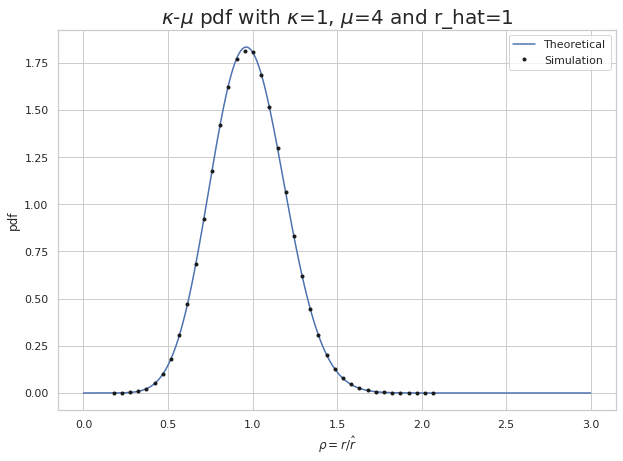

In [6]:
r = np.linspace(0, 3, 3000) # theoretical envelope PDF x axes
plt.figure(figsize=((10,7)))
plt.plot(r, ku._pdf(r), label='Theoretical')
plt.plot(ku.X[1:len(ku.X):2], ku.Y[1:len(ku.Y):2], "k.", label='Simulation')
plt.title(r'$\kappa$-$\mu$ pdf with $\kappa$={}, $\mu$={} and r_hat={}'.format(kappa,mu,r_hat), fontsize=20)
plt.legend()
plt.xlabel(r'$\rho=r/\hat{r}$')
plt.ylabel('pdf')
plt.show()

In [7]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,)) #-1 to minimze, +1 to maximize
creator.create("Individual", list, fitness=creator.FitnessMin)

# toolbox = base.Toolbox()

### One individual for each $\hat{\theta}_i$


In [8]:
toolbox = base.Toolbox()

In [9]:
toolbox.register("attr_bool", np.random.uniform, 0.1, 3)
toolbox.attr_bool()

toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, 3)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
print('random individual')
toolbox.individual()

random individual


[2.501036299244435, 2.053795903631361, 1.3955943203936803]

In [10]:
toolbox.register("evaluate", fitnessFunction)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutGaussian, mu=1, sigma= 0.5, indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=3)

In [11]:
pop = toolbox.population(n=1000)

In [12]:
hof = tools.ParetoFront()

In [13]:
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

In [14]:
# sortedPop = sorted(pop, key=lambda ind:ind.fitness)

In [15]:
pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.3,\
                               ngen=1000, stats=stats, halloffame=hof, verbose=True)

gen	nevals	avg     	std   	min       	max    
0  	1000  	0.678141	0.5751	0.00387501	4.00265
1  	645   	0.352371	0.19618	0.000684401	1.02732
2  	622   	0.204764	0.159669	0.000592283	0.956786
3  	641   	0.0999053	0.115807	0.000246417	0.857364
4  	628   	0.0516284	0.112317	0.000239041	0.810677
5  	662   	0.0326997	0.116747	0.000239041	1.39439 
6  	658   	0.0236237	0.10614 	0.000239041	0.886197
7  	660   	0.0206709	0.107288	0.000236974	0.92557 
8  	628   	0.0297501	0.141011	0.000229273	1.32482 
9  	642   	0.0223425	0.116134	0.000207115	0.888687
10 	676   	0.0189771	0.104097	0.000207115	1.02424 
11 	661   	0.0299777	0.138954	0.000207115	1.01846 
12 	662   	0.0288002	0.139977	0.000186814	0.930013
13 	655   	0.0155875	0.100612	0.000186814	0.948235
14 	646   	0.0287665	0.143904	0.000177731	1.10281 
15 	652   	0.0292177	0.14258 	0.00016302 	0.892788
16 	675   	0.0155968	0.102609	0.00016302 	0.803718
17 	636   	0.0222692	0.122313	0.00016302 	0.853346
18 	656   	0.0297435	0.144036	0.00016302 	1.3

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in multiply


714	686   	0.0202589 	0.117734 	9.86114e-06	0.911598
715	651   	0.0186172 	0.113136 	9.86114e-06	0.931609
716	635   	0.0228544 	0.142179 	9.86114e-06	2.51606 
717	637   	0.0227142 	0.123616 	9.86114e-06	0.934461
718	663   	0.0219382 	0.122097 	9.86114e-06	0.801998
719	627   	0.0151419 	0.103666 	9.86114e-06	0.952258
720	642   	0.0244738 	0.13133  	9.86114e-06	0.942771
721	668   	0.0229683 	0.124341 	9.86114e-06	0.850432
722	635   	0.0186021 	0.111871 	9.86114e-06	0.802025
723	678   	0.0174243 	0.110296 	9.86114e-06	0.925978
724	650   	0.0258214 	0.134698 	9.86114e-06	1.14012 
725	649   	0.026069  	0.131659 	9.8446e-06 	1.01448 
726	662   	0.0264097 	0.140404 	9.8446e-06 	1.84745 
727	650   	0.0268783 	0.139641 	9.8446e-06 	0.922504
728	651   	0.0205832 	0.119096 	9.8446e-06 	0.903686
729	653   	0.0237415 	0.130101 	9.8446e-06 	0.981679
730	656   	0.0181621 	0.112638 	9.8446e-06 	0.949341
731	610   	0.0199877 	0.119047 	9.8446e-06 	1.03198 
732	673   	0.0202145 	0.113929 	9.8446e-06 	0.

In [16]:
print('Current best fitness (MSE):', fitnessFunction(tools.selBest(pop, k=1)[0]))

Current best fitness (MSE): (9.844597145153352e-06,)


In [17]:
print('Best estimated parameters: ')
print('Kappa,              Mu,                R_hat')
hof[0]

Best estimated parameters: 
Kappa,              Mu,                R_hat


[1.1842107409317337, 3.749979258617405, 0.9998102487240061]

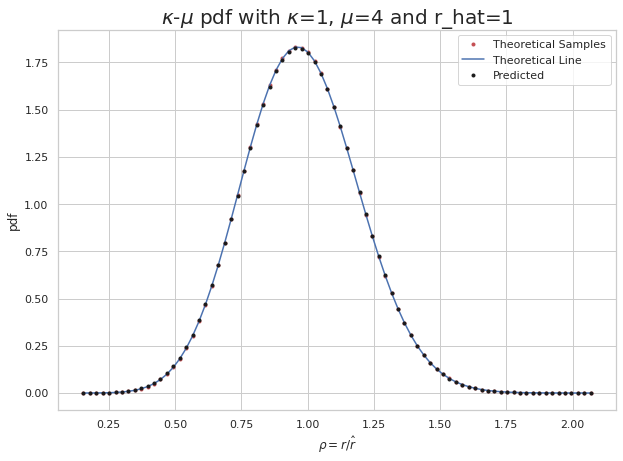

In [18]:
kappa = theta[0]
mu = theta[1]
r_hat = theta[2]
X = ku.X
Y = ku.Y
y_pred = computePDF(X, kappa, mu, r_hat)

plt.figure(figsize=(10,7))
plt.plot(X, y_pred,'.r', label='Theoretical Samples')
plt.plot(X, ku._pdf(X), label='Theoretical Line')
plt.plot(X, computePDF(X,hof[0][0],hof[0][1],hof[0][2]),'.k', label='Predicted')
plt.title(r'$\kappa$-$\mu$ pdf with $\kappa$={}, $\mu$={} and r_hat={}'.format(kappa,mu,r_hat), fontsize=20)
plt.legend()
plt.xlabel(r'$\rho=r/\hat{r}$')
plt.ylabel('pdf')
plt.show()

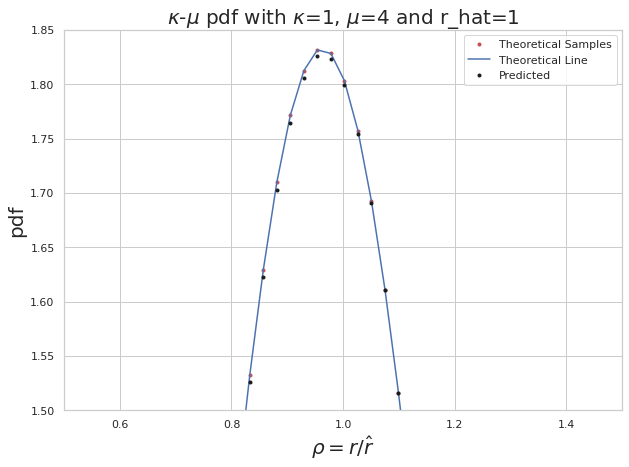

In [19]:
plt.figure(figsize=(10,7))
plt.plot(X, y_pred,'.r', label='Theoretical Samples')
plt.plot(X, ku._pdf(X), label='Theoretical Line')
plt.plot(X, computePDF(ku.X,hof[0][0],hof[0][1],hof[0][2]),'.k', label='Predicted')
plt.ylim((1.5,1.85))
plt.xlim((0.5,1.5))
plt.title(r'$\kappa$-$\mu$ pdf with $\kappa$={}, $\mu$={} and r_hat={}'.format(kappa,mu,r_hat), fontsize=20)
plt.legend()
plt.xlabel(r'$\rho=r/\hat{r}$', fontsize=20)
plt.ylabel('pdf', fontsize=20)
plt.show()

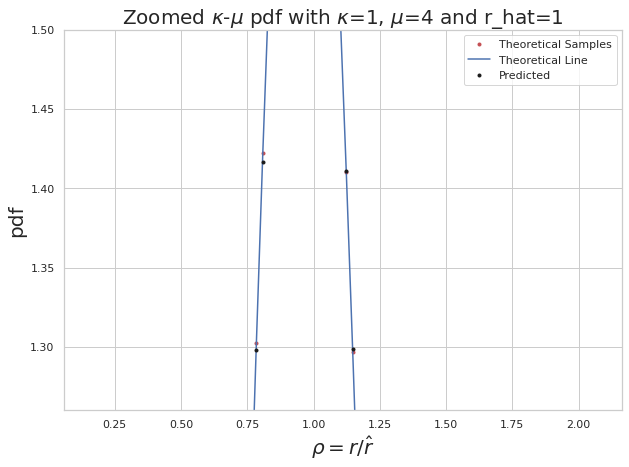

In [37]:
plt.figure(figsize=(10,7))
plt.plot(X, y_pred,'.r', label='Theoretical Samples')
plt.plot(X, ku._pdf(X), label='Theoretical Line')
plt.plot(X, computePDF(ku.X,hof[0][0],hof[0][1],hof[0][2]),'.k', label='Predicted')
plt.ylim((1.26,1.5))
plt.title(r'Zoomed $\kappa$-$\mu$ pdf with $\kappa$={}, $\mu$={} and r_hat={}'.format(kappa,mu,r_hat), fontsize=20)
plt.legend()
plt.xlabel(r'$\rho=r/\hat{r}$', fontsize=20)
plt.ylabel('pdf', fontsize=20)
plt.show()

In [21]:
print(r'PREDICTED: kappa is {}, mu is {} and r_hat is {}.'.format(hof.items[0][0], hof.items[0][1], hof.items[0][2]))
print('REAL: kappa={} mu={} r_hat={}'.format(theta[0], theta[1], theta[2]))

PREDICTED: kappa is 1.1842107409317337, mu is 3.749979258617405 and r_hat is 0.9998102487240061.
REAL: kappa=1 mu=4 r_hat=1


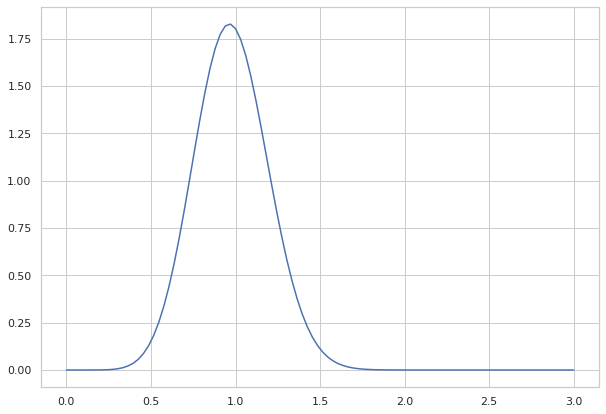

In [22]:
x_test = np.linspace(0+1e-4,3,100)
plt.figure(figsize=((10,7)))

plt.plot(x_test, computePDF(x_test, kappa=hof.items[0][0], mu=hof.items[0][1], r_hat=hof.items[0][2]),label=r'$\mu=0.5$')


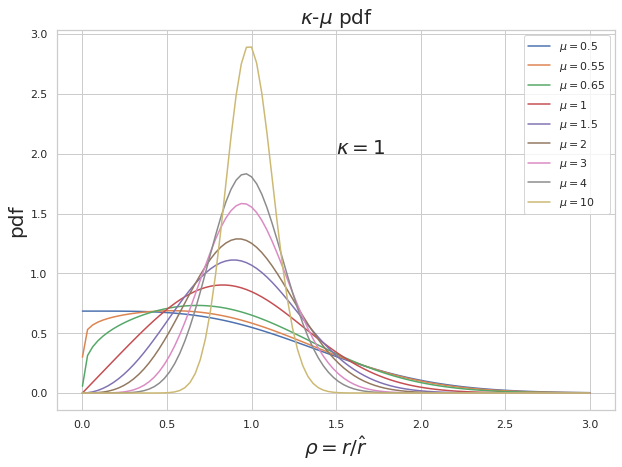

In [23]:
x_test = np.linspace(0+1e-4,3,100)
plt.figure(figsize=((10,7)))

plt.plot(x_test, computePDF(x_test, kappa=1, mu=0.5, r_hat=1),label=r'$\mu=0.5$')
plt.plot(x_test, computePDF(x_test, kappa=1, mu=0.55, r_hat=1),label=r'$\mu=0.55$')
plt.plot(x_test, computePDF(x_test, kappa=1, mu=0.65, r_hat=1),label=r'$\mu=0.65$')
plt.plot(x_test, computePDF(x_test, kappa=1, mu=1, r_hat=1),label=r'$\mu=1$')
plt.plot(x_test, computePDF(x_test, kappa=1, mu=1.5, r_hat=1),label=r'$\mu=1.5$')
plt.plot(x_test, computePDF(x_test, kappa=1, mu=2, r_hat=1),label=r'$\mu=2$')
plt.plot(x_test, computePDF(x_test, kappa=1, mu=3, r_hat=1),label=r'$\mu=3$')
plt.plot(x_test, computePDF(x_test, kappa=1, mu=4, r_hat=1),label=r'$\mu=4$')
plt.plot(x_test, computePDF(x_test, kappa=1, mu=10, r_hat=1),label=r'$\mu=10$')
plt.text(x=1.5, y=2, s=r'$\kappa=1$', size=20)
plt.title(r'$\kappa$-$\mu$ pdf', fontsize=20)
plt.legend()
plt.xlabel(r'$\rho=r/\hat{r}$', fontsize=20)
plt.ylabel('pdf', fontsize=20)
plt.show()

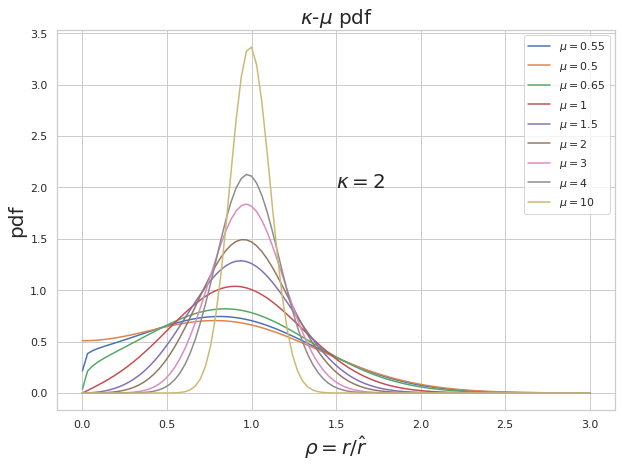

In [24]:
x_test = np.linspace(0+1e-4,3,100)

plt.figure(figsize=((10,7)))
plt.plot(x_test, computePDF(x_test, kappa=2, mu=0.55, r_hat=1),label=r'$\mu=0.55$')
plt.plot(x_test, computePDF(x_test, kappa=2, mu=0.5, r_hat=1),label=r'$\mu=0.5$')
plt.plot(x_test, computePDF(x_test, kappa=2, mu=0.65, r_hat=1),label=r'$\mu=0.65$')
plt.plot(x_test, computePDF(x_test, kappa=2, mu=1, r_hat=1),label=r'$\mu=1$')
plt.plot(x_test, computePDF(x_test, kappa=2, mu=1.5, r_hat=1),label=r'$\mu=1.5$')
plt.plot(x_test, computePDF(x_test, kappa=2, mu=2, r_hat=1),label=r'$\mu=2$')
plt.plot(x_test, computePDF(x_test, kappa=2, mu=3, r_hat=1),label=r'$\mu=3$')
plt.plot(x_test, computePDF(x_test, kappa=2, mu=4, r_hat=1),label=r'$\mu=4$')
plt.plot(x_test, computePDF(x_test, kappa=2, mu=10, r_hat=1),label=r'$\mu=10$')
plt.text(x=1.5, y=2, s=r'$\kappa=2$', size=20)
plt.title(r'$\kappa$-$\mu$ pdf', fontsize=20)
plt.legend()
plt.xlabel(r'$\rho=r/\hat{r}$', fontsize=20)
plt.ylabel('pdf', fontsize=20)
plt.show()

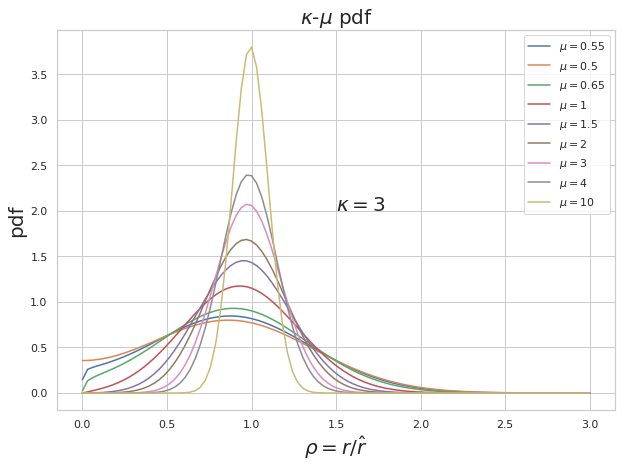

In [25]:
x_test = np.linspace(0+1e-4,3,100)

plt.figure(figsize=((10,7)))
plt.plot(x_test, computePDF(x_test, kappa=3, mu=0.55, r_hat=1),label=r'$\mu=0.55$')
plt.plot(x_test, computePDF(x_test, kappa=3, mu=0.5, r_hat=1),label=r'$\mu=0.5$')
plt.plot(x_test, computePDF(x_test, kappa=3, mu=0.65, r_hat=1),label=r'$\mu=0.65$')
plt.plot(x_test, computePDF(x_test, kappa=3, mu=1, r_hat=1),label=r'$\mu=1$')
plt.plot(x_test, computePDF(x_test, kappa=3, mu=1.5, r_hat=1),label=r'$\mu=1.5$')
plt.plot(x_test, computePDF(x_test, kappa=3, mu=2, r_hat=1),label=r'$\mu=2$')
plt.plot(x_test, computePDF(x_test, kappa=3, mu=3, r_hat=1),label=r'$\mu=3$')
plt.plot(x_test, computePDF(x_test, kappa=3, mu=4, r_hat=1),label=r'$\mu=4$')
plt.plot(x_test, computePDF(x_test, kappa=3, mu=10, r_hat=1),label=r'$\mu=10$')
plt.text(x=1.5, y=2, s=r'$\kappa=3$', size=20)
plt.title(r'$\kappa$-$\mu$ pdf', fontsize=20)
plt.legend()
plt.xlabel(r'$\rho=r/\hat{r}$', fontsize=20)
plt.ylabel('pdf', fontsize=20)
plt.show()

In [26]:
# data = pd.read_csv('/content/pathAB_SSF_dB_AP8_downsampled1Khz_win50.txt')

In [27]:
# data.describe()

In [28]:
# data.plot()

In [29]:
# data = np.sqrt(data)
# data.describe()

In [30]:
# data.plot()

In [31]:
# sns.distplot(data)

In [32]:
# data.dropna(inplace=True)

In [33]:
# data.plot()

In [34]:
# sns.distplot(data)

In [35]:
# data2 = data.copy()
# data = []
# for idx, var in enumerate(list(data2)):
#     myPlot = sns.distplot(data2[var])
    
#     # Fine Line2D objects
#     lines2D = [obj for obj in myPlot.findobj() if str(type(obj)) == "<class 'matplotlib.lines.Line2D'>"]
    
#     # Retrieving x, y data
#     x, y = lines2D[idx].get_data()[0], lines2D[idx].get_data()[1]
    
#     # Store as dataframe 
#     data.append(pd.DataFrame({'x':x, 'y':y}))